In [1]:
import os
os.chdir("..")

In [2]:
from skin_lesion_cad.utils.data_utils import get_class
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import time
import warnings
from pathlib import Path
mpl.rcParams['figure.dpi'] = 200


In [3]:
feature_dir = "data/processed/features"
CHALLENGE = "chall1"

In [4]:

def read_feats(color="raw"):
    save_path = Path("data/processed/features")

    glcm_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_glcm.feather"))
    lbp_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_lbp.feather"))
    color_df_raw_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_raw.feather"))
    color_df_ms_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_meanshift.feather"))

    glcm_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_glcm.feather"))
    lbp_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_lbp.feather"))
    color_df_raw_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_raw.feather"))
    color_df_ms_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_meanshift.feather"))

    dfs = [glcm_df_train, lbp_df_train, color_df_raw_train]
    all_feat_raw_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_train, lbp_df_train, color_df_ms_train]
    all_feat_ms_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_val, lbp_df_val, color_df_raw_val]
    all_feat_raw_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_val, lbp_df_val, color_df_ms_val]
    all_feat_ms_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)
    if color == "raw":
        return all_feat_raw_train, all_feat_raw_val
    elif color == "meanshift":
        return all_feat_ms_train, all_feat_ms_val


In [5]:

color = "raw"
all_feat_train, all_feat_val = read_feats("raw")

X = all_feat_train.drop(columns='image')
y = all_feat_train['image'].apply(get_class,chall=CHALLENGE)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_test = all_feat_val.drop(columns='image')
y_test = all_feat_val['image'].apply(get_class, chall=CHALLENGE)


In [12]:
X[np.isnan(X)] = 0
X[np.isinf(X)] = 0

X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_val[np.isinf(X_val)] = 0
X_test[np.isnan(X_test)] = 0
X_test[np.isinf(X_test)] = 0


In [13]:


#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train, y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy',
                    param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
val_predictions = clf0.predict(X_val)
unseen_predictions = clf0.predict(X_test)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_val, val_predictions)
cfm_unseen = confusion_matrix(y_test, unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_val, val_predictions)
accs_unseen = accuracy_score(y_test, unseen_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_val, val_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, unseen_predictions, pos_label=0)
f1s_unseen_p1 = f1_score(y_test, unseen_predictions, pos_label=1)
f1s_unseen_p0 = f1_score(y_test, unseen_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:, 1])
unseen_ras = roc_auc_score(
    y_test, clf0.predict_proba(X_test)[:, 1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'cfm_unseen': cfm_unseen,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'unseen_accuracy': accs_unseen,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'unseen F1-score label 1': f1s_unseen_p1,
                         'unseen F1-score label 0': f1s_unseen_p0,
                         'test roc auc score': test_ras,
                         'unseen roc auc score': unseen_ras,
                         'best_params': bp}


Fitting 3 folds for each of 1 candidates, totalling 3 fits


# Parameters tuning

In [14]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}


In [15]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X, y.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X)
    test_predictions = clf.predict(X_test)
    # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
    #confusion matrices
    cfm_train = confusion_matrix(y, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
    # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                #   'cfm_unseen': cfm_unseen,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                #   'unseen_accuracy': accs_unseen,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                #   'unseen F1-score label 1': f1s_unseen_p1,
                                #   'unseen F1-score label 0': f1s_unseen_p0,
                                  'test roc auc score': test_ras,
                                #   'unseen roc auc score': unseen_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0


Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 49.64884305000305 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 79.53284502029419 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 171.3711497783661 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 120.35901999473572 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 159.729829788208 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 255.80602598190308 seconds


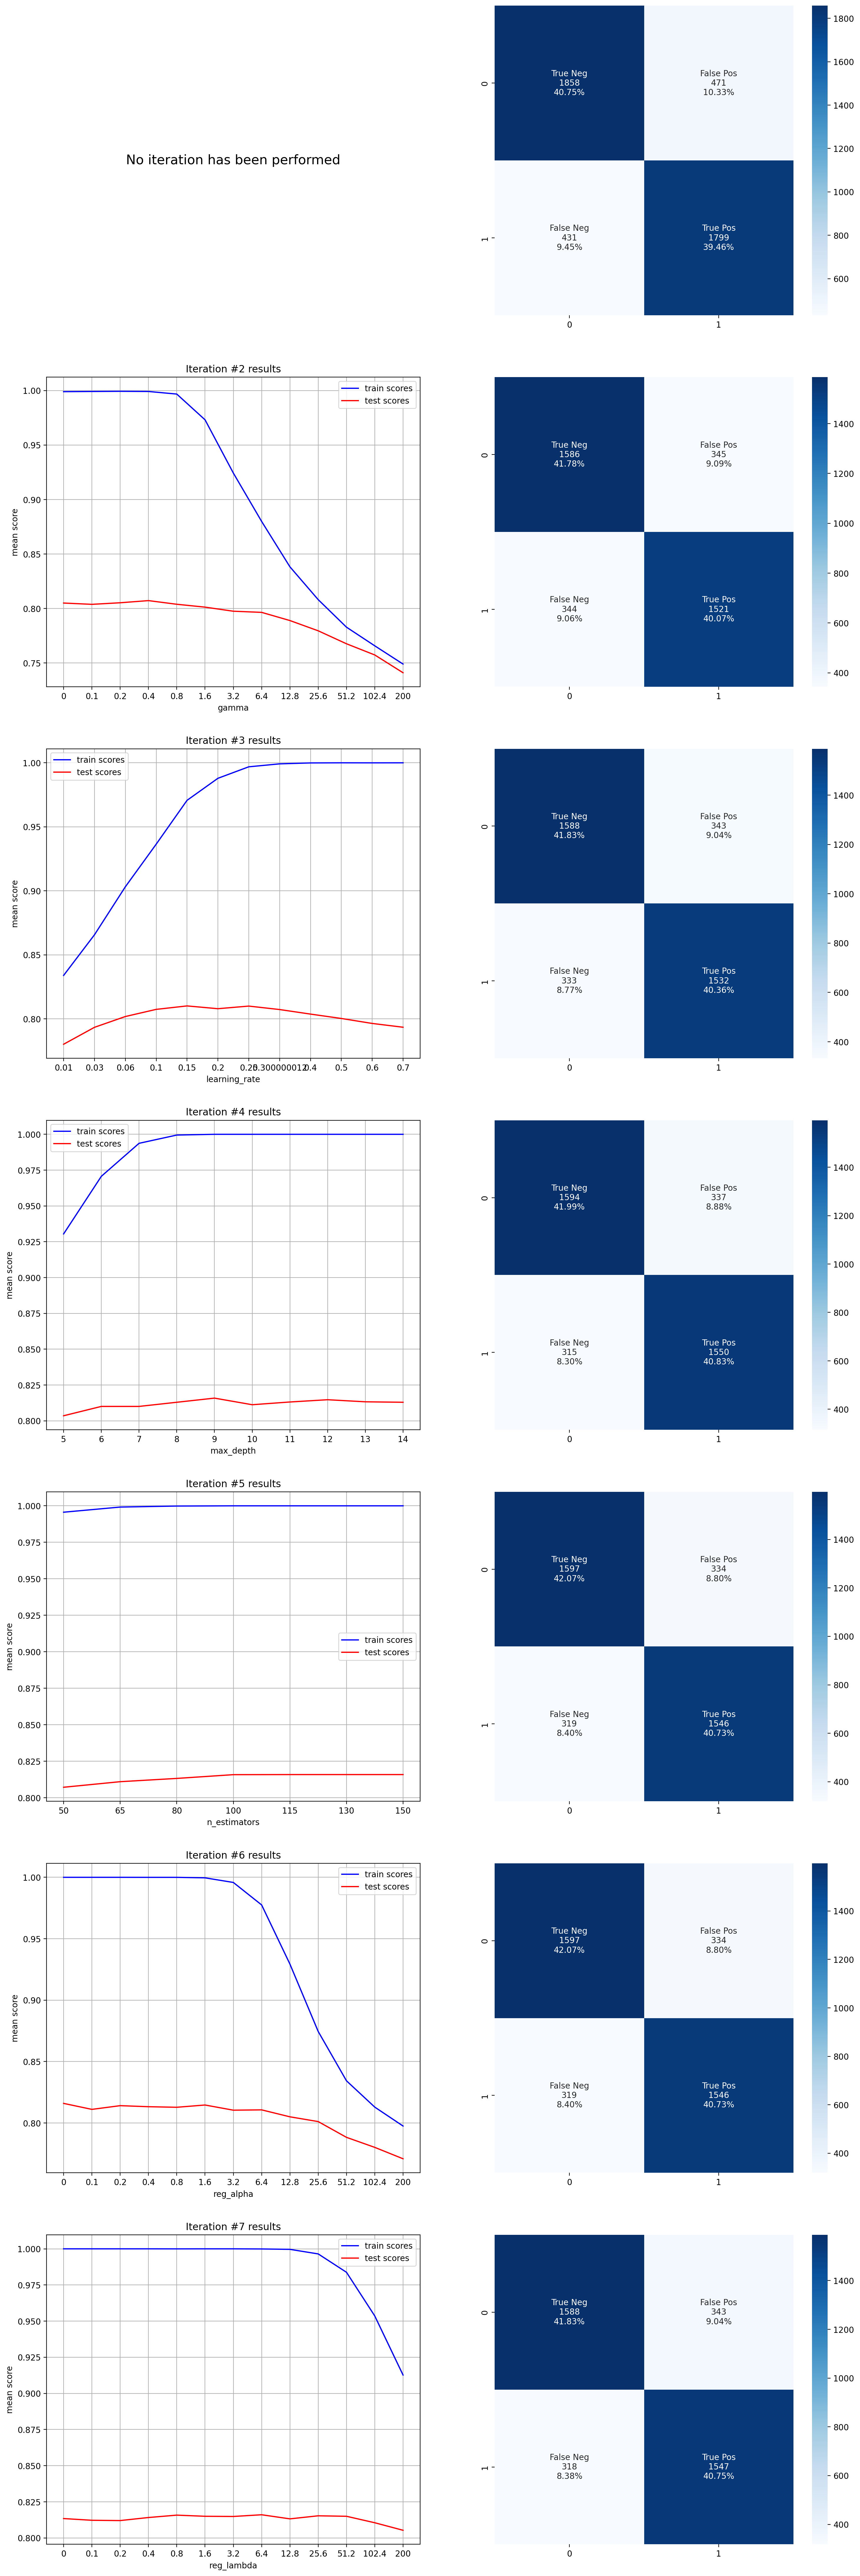

In [16]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();


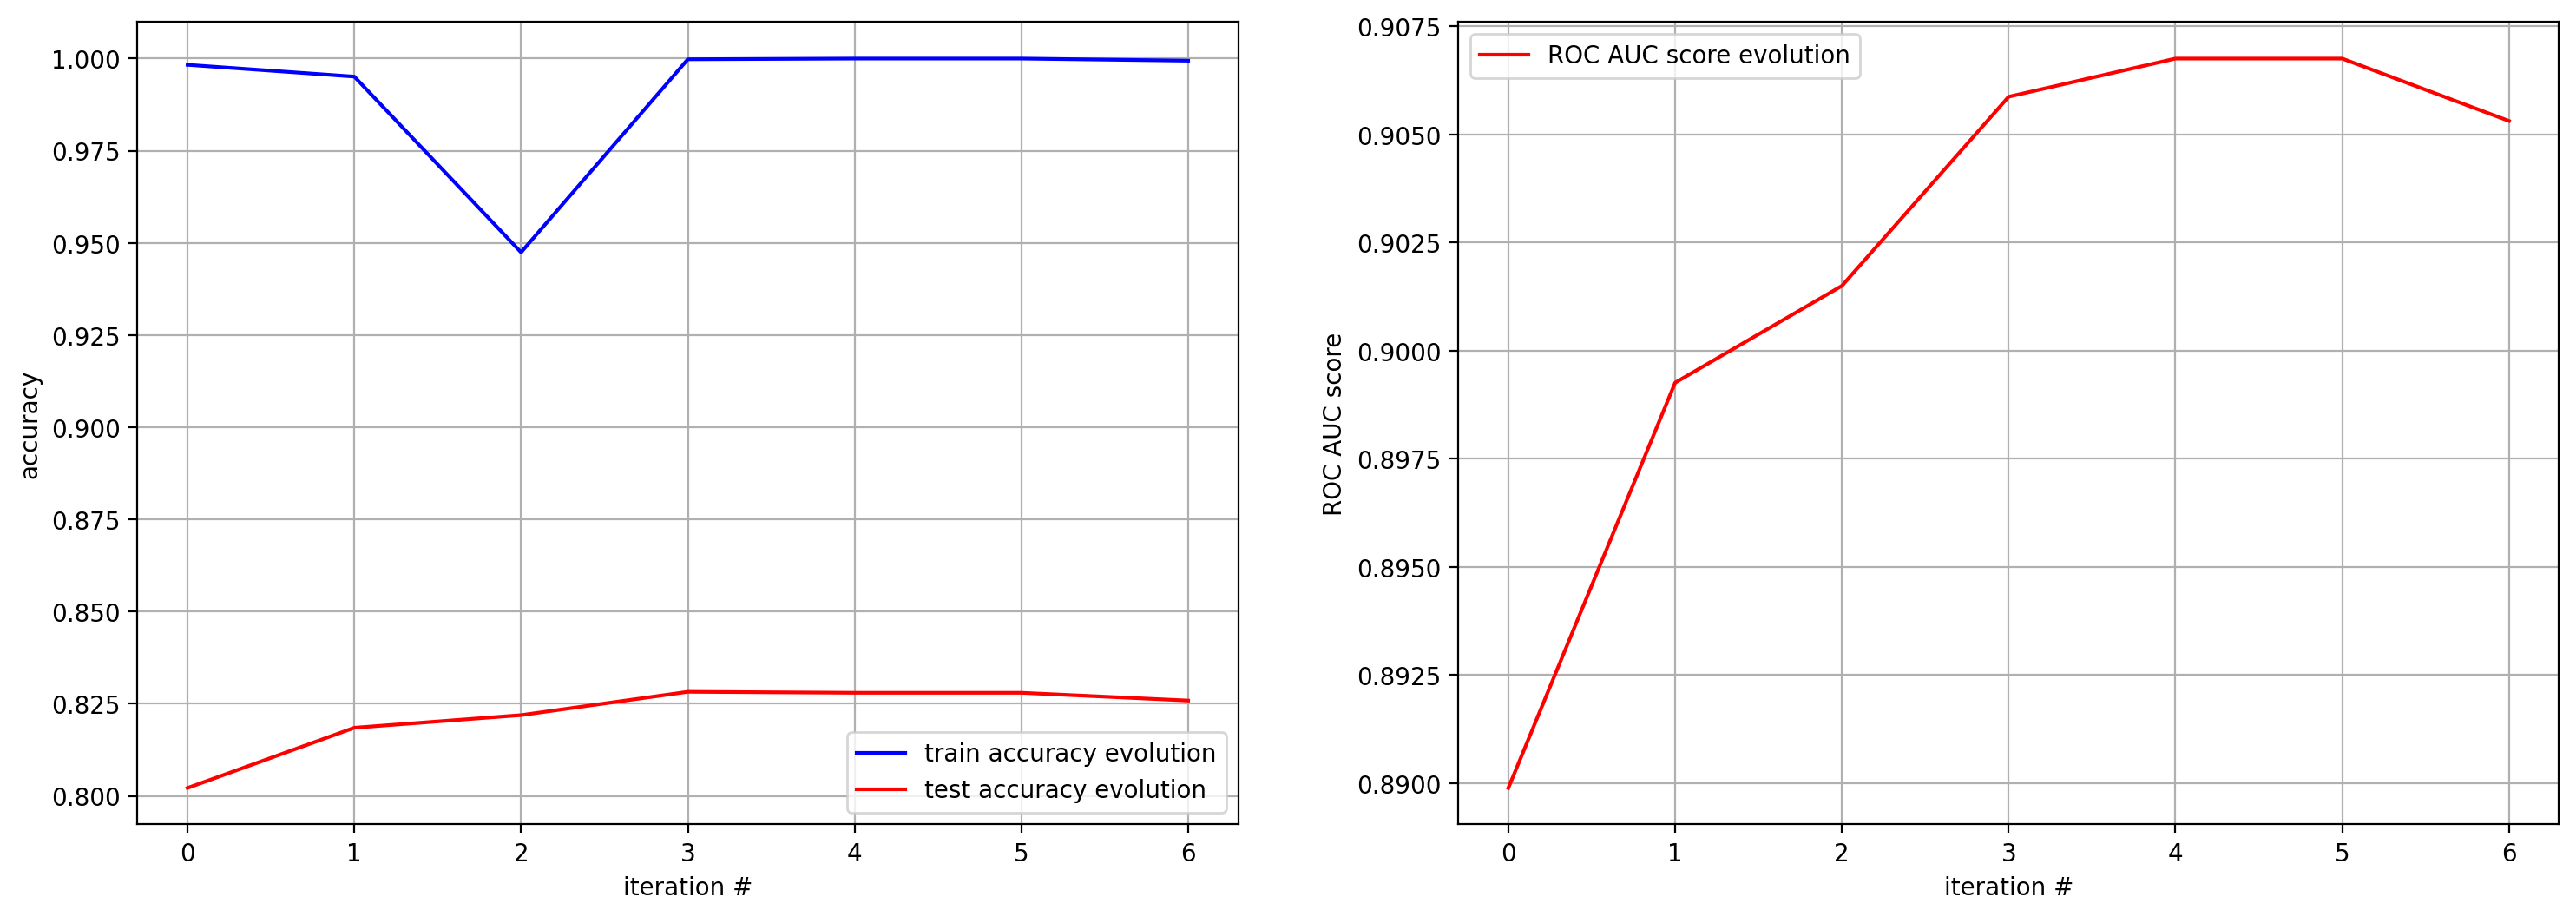

In [17]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys(
)], label='train accuracy evolution', color='blue')
axes[0].plot([results_dict[key]['test_accuracy']
             for key in results_dict.keys()], label='test accuracy evolution', color='red')

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid('major')

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score']
             for key in results_dict.keys()], label='ROC AUC score evolution', color='red')

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #')
axes[1].set_ylabel('ROC AUC score')
axes[1].legend()
axes[1].grid('major')

plt.show()


In [18]:
#start time
t0 = time.time()

#No. of jobs
rcvj = gcvj

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

#Executing Randomized Search
clf = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=1, cv=3, n_iter=rcvj)
clf.fit(X_train, y_train.values.ravel())
    
#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            # 'cfm_unseen': cfm_unseen,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            # 'unseen_accuracy': accs_unseen,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            # 'unseen F1-score label 1': f1s_unseen_p1,
                            # 'unseen F1-score label 0': f1s_unseen_p0,
                            'test roc auc score': test_ras,
                            # 'unseen roc auc score': unseen_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
rcvt = t1 - t0


Fitting 3 folds for each of 68 candidates, totalling 204 fits


In [19]:
#start time
t0 = time.time()

#No. of jobs
bcvj = int(gcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            # 'cfm_unseen': cfm_unseen,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            # 'unseen_accuracy': accs_unseen,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            # 'unseen F1-score label 1': f1s_unseen_p1,
                            # 'unseen F1-score label 0': f1s_unseen_p0,
                            'test roc auc score': test_ras,
                            # 'unseen roc auc score': unseen_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
bcvt = t1 - t0


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=51.2, learning_rate=0.300000012, max_depth=9, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2;, score=(train=0.784, test=0.757) total time=   0.4s
[CV 2/3] END gamma=51.2, learning_rate=0.300000012, max_depth=9, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2;, score=(train=0.780, test=0.776) total time=   0.4s
[CV 3/3] END gamma=51.2, learning_rate=0.300000012, max_depth=9, n_estimators=115, reg_alpha=0.8, reg_lambda=3.2;, score=(train=0.780, test=0.767) total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=51.2, learning_rate=0.25, max_depth=13, n_estimators=115, reg_alpha=12.8, reg_lambda=102.4;, score=(train=0.777, test=0.753) total time=   0.4s
[CV 2/3] END gamma=51.2, learning_rate=0.25, max_depth=13, n_estimators=115, reg_alpha=12.8, reg_lambda=102.4;, score=(train=0.770, test=0.762) total time=   0.5s
[CV 3/3] END gamma=51.2, learning_rate=0.25, max_depth=13,

In [20]:
#printing benchmark, iterative grid search and randomized search ROC AUC / accuracy scores (test data set)
print(
    f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(
    f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc3']['test roc auc score'],4)} / {np.round(results_dict['xgbc3']['test_accuracy'],4)} @ {np.round(gcvt/60,2)} minutes and {gcvj} jobs")
print(
    f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)} @ {np.round(rcvt/60,2)} minutes and {rcvj} jobs")
print(
    f"Bayes search AUC/accuracy score: {np.round(results_dict['xgbc_bcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_bcv']['test_accuracy'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print("")

#computing expected time of executing exhaustive grid search
jobs = np.cumprod([len(x) for x in param_grid])[-1]
et = jobs * gcvt / gcvj
print(
    f"Expected time of executing exhaustive grid search with 3-fold cross-validation: {int(et/60)} minutes and {jobs} jobs")


Benchmark AUC/accuracy score: 0.8899 / 0.8021
Coordinate descent AUC/accuracy score: 0.9059 / 0.8282 @ 13.94 minutes and 68 jobs
Randomized search AUC/accuracy score: 0.8983 / 0.8182 @ 6.21 minutes and 68 jobs
Bayes search AUC/accuracy score: 0.8993 / 0.8217 @ 26.06 minutes and 68 jobs

Expected time of executing exhaustive grid search with 3-fold cross-validation: 129526 minutes and 631800 jobs


In [23]:
results_dict['xgbc3']['best_params']

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'gamma': 0.4,
 'gpu_id': -1,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.15,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 9,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'hist',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}